In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

from IPython.display import clear_output

BATCH_SIZE = 256

format = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

    transforms.RandomCrop((400, 400)),
    transforms.RandomRotation(180),

    transforms.CenterCrop((282, 282)), # 282 ~= 400 * (1/sqrt(2))
    transforms.Resize((256, 256), transforms.InterpolationMode.NEAREST),

    transforms.RandomApply(p=0.2, transforms=[transforms.GaussianBlur(5, sigma=(.5, 12))]),
    transforms.RandomApply(p=0.2, transforms=[transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.5)]),

    transforms.ToTensor(),
])

ds = datasets.Flowers102(root='../pytorch-datasets/', split='train', transform=format, download=True)
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

In [2]:
def random_1d_slice(batch, num_samples):
    lines, points = [], []
    b, c, h, w = batch.shape
    for img in batch:
        x1, y1 = np.random.randint(0, w), np.random.randint(0, h)
        x2, y2 = np.random.randint(0, w), np.random.randint(0, h)
        x = torch.linspace(x1, x2, num_samples, dtype=torch.int)
        y = torch.linspace(y1, y2, num_samples, dtype=torch.int)
        random_slices = []
        for channel in img:
            random_slices.append(channel[y, x])
        points.append(torch.stack([x, y]))
        lines.append(torch.stack(random_slices))
    return torch.stack(lines), torch.stack(points)

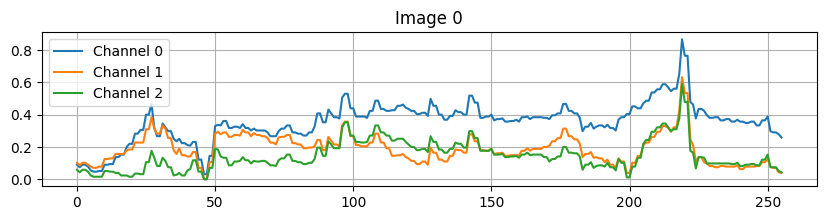

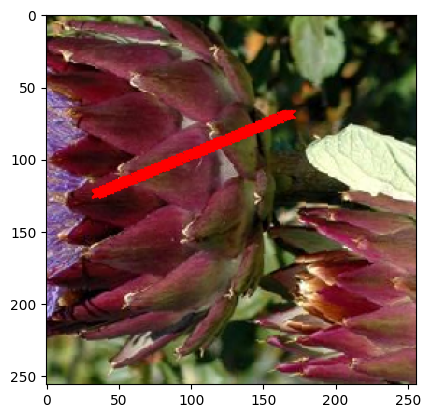

In [3]:
NUM_SAMPLES = 256
batch, labels = next(iter(dl))
data, points = random_1d_slice(batch, NUM_SAMPLES)

# Plot the lines
for i, random_slices in enumerate(data):
    plt.figure(figsize=(10, 2))
    for j, line in enumerate(random_slices):
        plt.plot(line.numpy(), label=f'Channel {j}')
    plt.grid(True)
    plt.title(f'Image {i}')
    plt.legend()
    plt.show()
    plt.imshow(batch[i].permute(1, 2, 0))
    plt.scatter(points[i][0], points[i][1], c='red', marker='x')
    plt.show()
    break

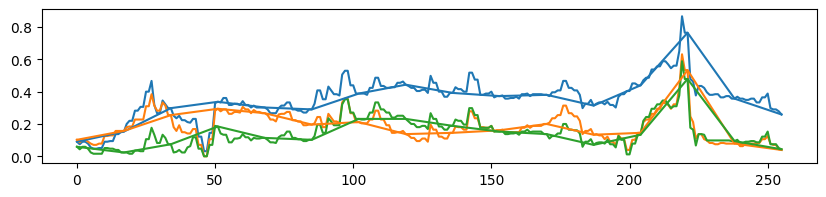

torch.Size([256, 3, 16])

In [4]:
KEY_SIZE = 16
key = F.interpolate(data, size=KEY_SIZE, mode='linear', align_corners=True)
plt.figure(figsize=(10, 2))
plt.plot(data[0,:,:].permute(1, 0).numpy())
plt.gca().set_prop_cycle(None)
plt.plot(np.linspace(0, NUM_SAMPLES-1, KEY_SIZE), key[0,:,:].permute(1, 0).numpy())
plt.show()
key.shape

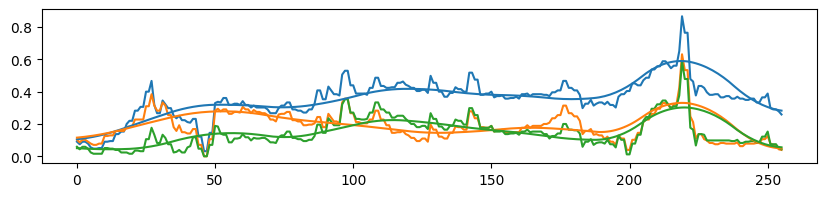

torch.Size([256, 3, 256])

In [5]:
basis = F.interpolate(key, size=NUM_SAMPLES, mode='linear', align_corners=True)

pad_size = 16
kernel_size = 2*pad_size + 1
basis = F.pad(basis, (pad_size, pad_size), mode='replicate')
basis = F.conv1d(basis, torch.ones(3, 1, kernel_size)/kernel_size, groups=3, padding=0, stride=1)


plt.figure(figsize=(10, 2))
plt.plot(data[0].permute(1, 0).numpy())
plt.gca().set_prop_cycle(None)
plt.plot(basis[0].permute(1, 0).numpy())
plt.show()
basis.shape

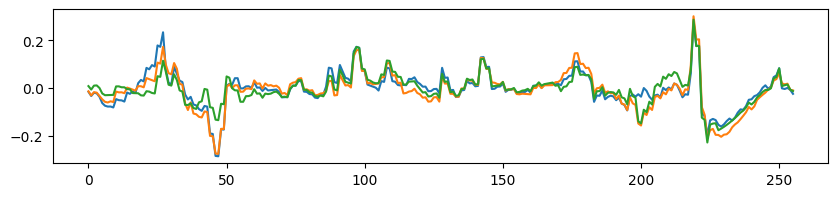

In [6]:
target = data-basis
plt.figure(figsize=(10, 2))
plt.plot(target[0].permute(1, 0).numpy())
plt.show()

In [7]:
class Learner(nn.Module):
    def __init__(self, key_size, out_size):
        super(Learner, self).__init__()
        assert key_size*8 < out_size, 'key_size is too large relative to out_size'
        self.key_size = key_size
        self.out_size = out_size
        self.decoder = nn.Sequential(
            nn.Linear(key_size, key_size*2),
            nn.ReLU(),
            nn.Linear(key_size*2, key_size*4),
            nn.ReLU(),
            nn.Linear(key_size*4, out_size//2),
            nn.ReLU(),
            nn.Linear(out_size//2, out_size) )
        for l in [0, 2, 4]:
            nn.init.kaiming_normal_(self.decoder[l].weight, nonlinearity='relu')
            nn.init.zeros_(self.decoder[l].bias)
        nn.init.normal_(self.decoder[6].weight, 0, 0.01)
        nn.init.zeros_(self.decoder[6].bias)

    def forward(self, key):
        return self.decoder(key)

In [8]:
model = Learner(KEY_SIZE, NUM_SAMPLES).cuda()
key = key.cuda()
target = target.cuda()
with torch.no_grad():
    pred = model(key.cuda())
pred.shape

torch.Size([256, 3, 256])

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch 19900 Loss 0.0005380252841860056


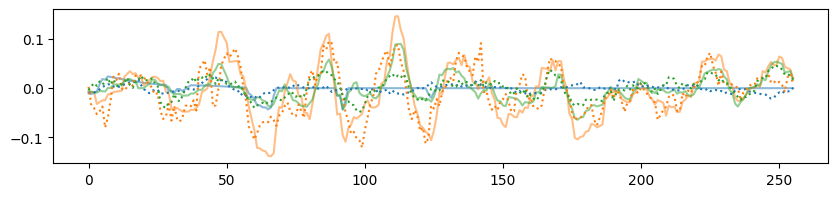

In [10]:
EPOCHS = 20000

model.train()
for epoch in range(EPOCHS):
    pred = model(key)
    loss = criterion(pred, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        clear_output(wait=True)
        print(f'Epoch {epoch} Loss {loss.item()}')
        plt.figure(figsize=(10, 2))
        plt.plot(target[2,:,:].cpu().permute(1, 0).numpy(), alpha=0.5)
        plt.gca().set_prop_cycle(None)
        plt.plot(pred[2,:,:].detach().cpu().permute(1, 0).numpy(), linestyle='dotted')
        plt.show()

In [14]:
with torch.no_grad():
    model = model.cpu()
    key = key.cpu()
    pred = model(key)

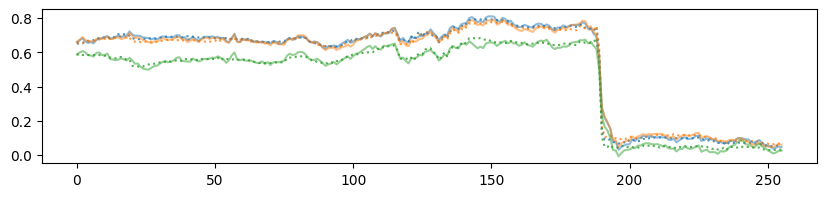

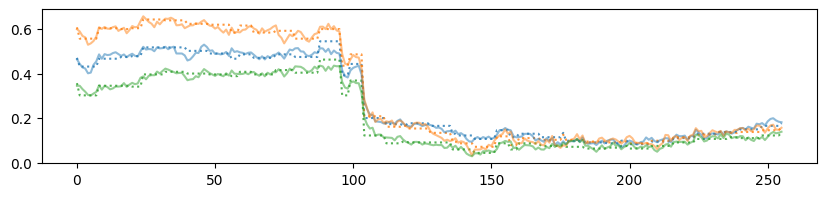

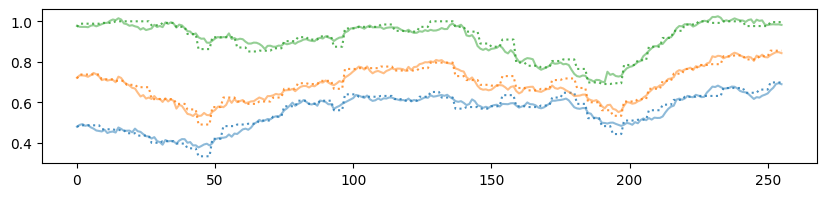

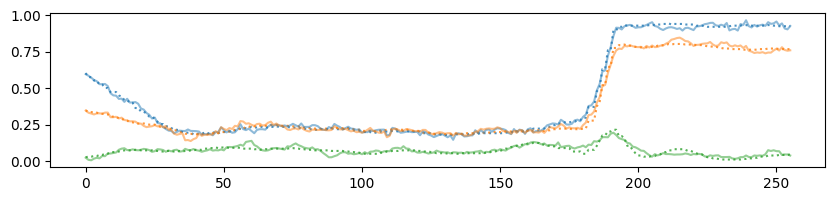

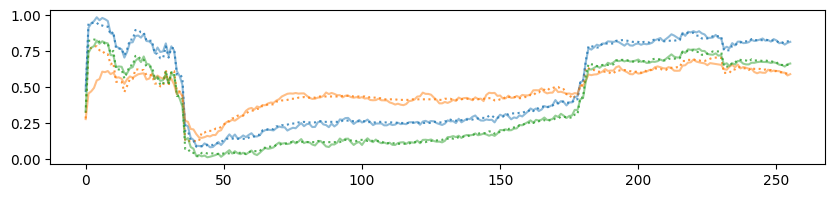

In [15]:
for index in range(5, 10):
    plt.figure(figsize=(10, 2))
    plt.plot(data[index].permute(1, 0).numpy(), alpha=0.8, linestyle='dotted')
    plt.gca().set_prop_cycle(None)
    plt.plot((pred[index] + basis[index]).permute(1, 0).numpy(), alpha=0.5)
    plt.show()

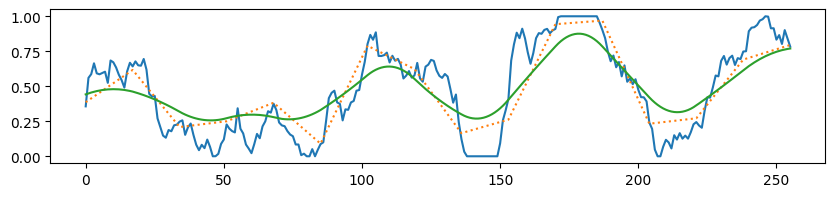

(torch.Size([1, 1, 16]), torch.Size([1, 1, 256]))

In [24]:
with torch.no_grad():
    rand_key = torch.rand(1, 1, KEY_SIZE)
    # rand_key = key[0:1, 0:1, :].clone()
    # rand_key[0, 0, 0] -= 0.13
    # rand_key[0, 0, 6] += 0.14

    rand_basis = F.interpolate(rand_key, size=NUM_SAMPLES, mode='linear', align_corners=True)
    rand_basis = F.pad(rand_basis, (pad_size, pad_size), mode='replicate')
    rand_basis = F.conv1d(rand_basis, torch.ones(1, 1, kernel_size)/kernel_size, groups=1, padding=0, stride=1)

    rand_pred = model(rand_key)

    plt.figure(figsize=(10, 2))
    plt.plot(torch.clamp(rand_basis+rand_pred, 0, 1)[0].permute(1, 0).numpy())
    plt.plot(np.linspace(0, NUM_SAMPLES-1, KEY_SIZE), rand_key[0, 0].numpy(), linestyle='dotted')
    plt.plot(rand_basis[0].permute(1, 0).numpy())
    plt.show()
    
rand_key.shape, rand_pred.shape